# Data Mining / Prospecção de Dados - 2022/2023

## Data Mining TP06 - Finding Similar items with Locality Sensitivity Hashing

#### A little Data Mining Tutorial by André Falcão - 2022-2023


## Summary

1. Fingerprints and Shingles
2. MinHashing
3. Locality Sensitivity Hashing
    1. A simple implementation
    2. Optimizing the performance



## 1. Fingerprints and Shingles

Similarity searching is a very difficult computational problem. When there are many documents and many characteristics, it is computationally prohibitive to compute distance matrices. In a medium sized database of 1,000,000 items, this implies a $5 x 10^{11}$ matrix. Even finding the most relevant documents o a new one can be very difficult as it always implies comparing similarities to ALL existing items in the database 

The type of methods we will use for similarity searching are binary based, meaning that items need to be described in a binary format, for presence or absense of characteristics. Mnay types of complex objects can be described in such a way: Text, graphics, sounds, genes, molecules,... 

Typically these matrices are very sparse, with many more zeros (absense of characteristic) than ones, presence of characteristic. 

There are several variations on the methods we will use that allow use them with some adjustments 

### 1.1. Requirements

For this presentation and class we will use
* Binary matrices for item description
* Jaccard Similarity for item comparison

Other similarity mesures might be used, sometimes with small adjustments on the procedures


In [1]:
import matplotlib.pyplot as plt
import numpy as np

Lets' start by creating a small random dataset of 6 documents with 12 features. We will set artifitially the sparsity of the document to 0.6, meaning that there will approximately  60% zeros and 40% ones

In [2]:
N=6
M=12
np.random.seed(2)
Docs=(np.random.random((N,M))>0.6)*1
print(Docs)

[[0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 1 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 1 1 0 1 0 0 0 0 1]
 [0 1 0 0 0 1 0 0 0 0 1 1]
 [1 1 1 0 0 0 0 0 1 0 0 0]]


The Jaccard similarity is a measure between two binary arrays and it is the ratio between the "set" bits (value=1) that both arrays share and all the bits that are set in both arrays: thus

$$
JaccardSim=\frac{A \cap B}{A \cup B}
$$

The Jaccard Similarity also has a different interpretation: it specifies **for each 1-bit present in both different instances, what is the probability that it is shared**

### Supplement: Performance of Jaccard Similarity

Two different approaches can be used for fast Jaccard Similarity computation.
* One that uses Set based operations (ratio of Intersection vs Union)
* an arithmetic based one, that uses the vector inner product and the vector addition

Both approaches have different performance advantages, depending on the vize of the feature space and the data sparsity 

First let's just compute the similarities using the arithmetic approach

In [3]:
def JaccardSimS(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

def JaccardSim(d1, d2):
    a =np.inner(d1,d2)
    bc=np.sum(d1+d2)-a
    return a/bc

d1,d2=0,4
print(Docs[d1])
print(Docs[d2])
print ("Jaccard Similarity between docs %d and %d is: %7.4f" %(d1,d2,JaccardSim(Docs[d1], Docs[d2])))
       
d1,d2=3,5
print(Docs[d1])
print(Docs[d2])
print ("Jaccard Similarity between docs %d and %d is: %7.4f" %(d1,d2,JaccardSim(Docs[d1], Docs[d2])))

[0 0 0 0 0 0 0 1 0 0 1 0]
[0 1 0 0 0 1 0 0 0 0 1 1]
Jaccard Similarity between docs 0 and 4 is:  0.2000
[1 0 0 1 1 0 1 0 0 0 0 1]
[1 1 1 0 0 0 0 0 1 0 0 0]
Jaccard Similarity between docs 3 and 5 is:  0.1250


In [43]:
def to_set(sparse_arr):
    sparse_arr = np.array(sparse_arr)
    values = np.arange(len(sparse_arr), dtype=int)
    return set(values[sparse_arr==1])

In [9]:
d1,d2=0,4
print(to_set(Docs[d1]))
print(to_set(Docs[d2]))
print ("Jaccard Similarity between docs %d and %d is: %7.4f" %(d1,d2,JaccardSimS(to_set(Docs[d1]), to_set(Docs[d2]))))
       
d1,d2=3,5
print(to_set(Docs[d1]))
print(to_set(Docs[d2]))
print ("Jaccard Similarity between docs %d and %d is: %7.4f" %(d1,d2,JaccardSimS(to_set(Docs[d1]), to_set(Docs[d2]))))


{10, 7}
{1, 10, 11, 5}
Jaccard Similarity between docs 0 and 4 is:  0.2000
{0, 3, 4, 6, 11}
{0, 1, 2, 8}
Jaccard Similarity between docs 3 and 5 is:  0.1250


Now let's check the performance of both approaches

In [10]:
s1=set(np.arange(M)[Docs[d1]==1])
s2=set(np.arange(M)[Docs[d2]==1])
print("Performance of Arithmetic Approach")
%timeit JaccardSim(Docs[d1], Docs[d2])
print("Performance of Set Based Approach")
%timeit JaccardSimS(s1, s2)

Performance of Arithmetic Approach
9.2 µs ± 182 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Performance of Set Based Approach
560 ns ± 13.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Yet for a larger dataset, the comparison changes dramatically. Let's create 2 random "documents" with 12,000 features

In [19]:
NL=2
ML=12000
np.random.seed(2)
LDocs=(np.random.random((NL,ML))>0.95)*1
s1=set(np.arange(ML)[LDocs[0]==1])
s2=set(np.arange(ML)[LDocs[1]==1])
print("Performance of Arithmetic Approach")
%timeit JaccardSim(LDocs[0], LDocs[1])
print("Performance of Set Based Approach")
%timeit JaccardSimS(s1, s2)#JaccardSimS(s1, s2), JaccardSim(Docs[0], Docs[1])

Performance of Arithmetic Approach
30.4 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Performance of Set Based Approach
44.2 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Exercises
1. Change the sparsity and verify the impact on performnce
    - Higher sparsity better performance for *Set* scenario, lower, worst
    - For the *Arithmetic* there is no difference
2. Discuss: How relevant is this issue on distance computation in a real world scenario


### Using Jaccard score to find similar documents

If we want to check all pairs of documents that have at a similar above a given threshold we have to check all possible combinations

Here we will look for all pairs sharing a similarity above 0.5

In [20]:
for d1 in range(N-1):
    for d2 in range(d1+1, N):
        J = JaccardSim(Docs[d1], Docs[d2])
        if J>0.5 and d1!=d2: 
            print(d1, d2, "Jaccard Similar:", J)
                             

1 3 Jaccard Similar: 0.6


## 2. Definition of Min Hashing

Min hashing is a procedure were we will try to identify for each element (document) how distant from a random column position is there a set bit (a one) 

For instance Document 1: 

`[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]`

given permutation of bits `[ 5, 11,  0,  2,  9,  1,  8,  6,  3,  4,  7, 10]`

1. For position 5,  there is a 0
2. For position 11, there is a 0
3. For position 0,  there is a 0
4. For position 2,  there is a 0
5. For position 9,  there is a 0
6. For position 1,  there is a 0
7. For position 8,  there is a 0
8. For position 6,  there is a 1

Therefore for Document 1, given the above bit permutation, **its minhash value is 7**

For the same permutation but now for document 3:

```
P = [ 5, 11,  0,  2,  9,  1,  8,  6,  3,  4,  7, 10]

D =  [1,   0,  0,  1,  1,  0,  1,  0,  0,  0,  0, 1]`
```

1. For position 5,  there is a 0
2. For position 11, there is a 1

Therefore for Document 3, given the above bit permutation, **its minhash value is 1**


We can generate a set of permutations using the numpy  `random.permutation` method

In [21]:
P=4
perms=np.array([np.random.permutation(M) for i in range(P)])
perms

array([[ 4,  2, 10,  1,  6,  0,  7,  5,  3,  9, 11,  8],
       [ 8,  5,  9,  6,  1,  0,  4, 10,  3,  2, 11,  7],
       [ 4,  6,  3, 11,  9,  5,  1,  2,  7,  0, 10,  8],
       [ 1, 11,  8,  0, 10,  6,  5,  9,  7,  4,  2,  3]])

#### Exercise:
* For the first permutation above compute **by hand** the minhash value for the first 3 documents:

```
Doc 0: [0 0 0 0 0 0 0 1 0 0 1 0]
Doc 1: [0 0 0 1 1 0 1 0 0 0 0 0]
Doc 2: [0 0 0 0 0 0 0 0 1 0 0 0]
```

### Automating Minhash computation
We can automate the procedure for computing the minhash value of a set of documents

In [48]:
perms=np.array([np.random.permutation(M) for i in range(P)])
perms

array([[ 9,  8,  3,  2,  0, 10, 11,  5,  1,  4,  7,  6],
       [ 8,  3,  7,  2,  1,  5,  9,  4, 11, 10,  0,  6],
       [ 3,  6,  2,  9,  4,  0, 11,  1, 10,  8,  5,  7],
       [ 6,  7,  3,  0,  5,  8,  2, 11, 10,  4,  9,  1]])

In [49]:
#mmds min hashing
print(M)
print("Minhash values of 4 random permutations over 6 documents")
signatures_a = [[] for _ in Docs]
for p, perm in enumerate(perms):
    print("Permutation:",p, " - ", end= " ")
    for d, doc in enumerate(Docs):
        for i, e in enumerate(doc):
            if e==1:
                print("%2d" %perm[i], end=" ")
                signatures_a[d].append(perm[i])
                break
    print()

12
Minhash values of 4 random permutations over 6 documents
Permutation: 0  -   5  2  1  9  8  9 
Permutation: 1  -   4  2 11  8  3  8 
Permutation: 2  -   1  9 10  3  6  3 
Permutation: 3  -  11  0 10  6  7  6 


In [50]:
signatures_a

[[5, 4, 1, 11],
 [2, 2, 9, 0],
 [1, 11, 10, 10],
 [9, 8, 3, 6],
 [8, 3, 6, 7],
 [9, 8, 3, 6]]

In [51]:
#min hashing 
print(M)
print("Minhash values of 4 random permutations over 6 documents")
signatures_b = [[] for _ in Docs]
for p, perm in enumerate(perms):
    print("Permutation:",p, " - ", end= " ")
    for d, doc in enumerate(Docs):
        for i, e in enumerate(perm):
            if doc[e]==1: 
                print("%2d" %i, end=" ")
                signatures_b[d].append(i)
                break
    print()


12
Minhash values of 4 random permutations over 6 documents
Permutation: 0  -   5  2  1  2  5  1 
Permutation: 1  -   2  1  0  1  4  0 
Permutation: 2  -   8  0  9  0  6  2 
Permutation: 3  -   1  0  5  0  4  3 


In [52]:
signatures_b

[[5, 2, 8, 1],
 [2, 1, 0, 0],
 [1, 0, 9, 5],
 [2, 1, 0, 0],
 [5, 4, 6, 4],
 [1, 0, 2, 3]]

In [53]:
d1,d2=0,4
print((s1:=set(signatures_a[d1])))
print((s2:=set(signatures_a[d2])))
print ("Jaccard Similarity between sigs_a %d and %d is: %7.4f" %(d1,d2,JaccardSimS(s1, s2)))
       
print((s1:=set(signatures_b[d1])))
print((s2:=set(signatures_b[d2])))
print ("Jaccard Similarity between sigs_b %d and %d is: %7.4f" %(d1,d2,JaccardSimS(s1, s2)))

{1, 11, 4, 5}
{8, 3, 6, 7}
Jaccard Similarity between sigs_a 0 and 4 is:  0.0000
{8, 1, 2, 5}
{4, 5, 6}
Jaccard Similarity between sigs_b 0 and 4 is:  0.1667


In [54]:
d1,d2=3,5
print((s1:=set(signatures_a[d1])))
print((s2:=set(signatures_a[d2])))
print ("Jaccard Similarity between sigs_a %d and %d is: %7.4f" %(d1,d2,JaccardSimS(s1, s2)))
       
print((s1:=set(signatures_b[d1])))
print((s2:=set(signatures_b[d2])))
print ("Jaccard Similarity between sigs_b %d and %d is: %7.4f" %(d1,d2,JaccardSimS(s1, s2)))

{8, 9, 3, 6}
{8, 9, 3, 6}
Jaccard Similarity between sigs_a 3 and 5 is:  1.0000
{0, 1, 2}
{0, 1, 2, 3}
Jaccard Similarity between sigs_b 3 and 5 is:  0.7500


## 3. Locality Sensitive Hashing (LSH)

### 3.1.  Probabilities of finding similar documents
The theory behind LSH is that similar documents will share identical partial signatures

A signature matrix is a matrix (like the one above) where for every document (in columns) we have the min hashing values for every random permutation.

One critical thing in the signature matrix is that it is divided in bands and rows. A band is contituded by a set of rows. This defines the number of permutations to use

* if we have 4 bands (B=4) and 3 rows (R=3) per band we will have $P=B\times R$, thus $P = 4 \times 3 =12$ permutations


**It has been shown that the probabilty that two signatures have the same value for two different documents is equivalent to the Jaccard similarity ($s$ )between those two documents**

* So a band composed of *R* rows has  a probability of matching all rows of $s^R$
* The probability that they disagree in at least one row in one band it is: $1-s^R$
* The probability that two signatures are different in at least one row of any band is thus $(1-s^R)^B$
* The probability that the signatures agree in all the rows of at least one band is then  $1 - (1-s^R)^B$

This final expression is the probability that 2 documents with a specified Jaccard similarity are selected as candidate pairs given a number of Rows and Bands

Using $R=5$ and $B= 20$, **any two documents 60% similar** that match at least one band have a probability of appearing as candidate pairs as

$$
P(sim(A,B)=0.6) = 1-(1-0.6^5)^{20} = 0.8019
$$

Which implies that we have a ~20% probability that documents with similarity 60% will not be found. On the other hand, **if the documents are 80% similar**, the probability of finding them as candidate pairs is:

$$
P(sim(A,B)=0.8) = 1-(1-0.8^5)^{20} = 0.9996
$$

This actually means we will have very few **false negatives**, ( a ratio about 0.0004 or about 1 in 3000), for every pair of documents at least 80% similar that will not share at least one band

Let's check it

In [55]:
B=20
R=5
s=0.6
print("The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f" %(s, 1-(1-s**R)**B))
s=0.8
print("The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f" %(s, 1-(1-s**R)**B))


The probability that documents share at least one band signature if they are 0.60 similar is:  0.8019
The probability that documents share at least one band signature if they are 0.80 similar is:  0.9996


We can verify it graphically by plotting the similarity of two documents against the probability of being candidate pairs with a given R and B parameters

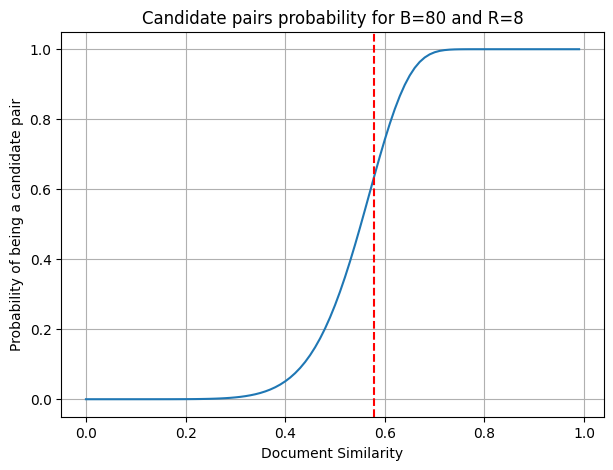

In [56]:
def DrawSimPlot(B, R):
    S=np.arange(0,1.0,.01)
    v=(1/B)**(1/R)
    P=1-(1-S**R)**B
    plt.figure(figsize=(7,5))
    plt.plot(S,P)
    plt.axvline(x = v, linestyle ="--", color ='r')
    plt.title("Candidate pairs probability for B=%d and R=%d" % (B,R))
    plt.xlabel("Document Similarity")
    plt.ylabel("Probability of being a candidate pair")

    plt.grid()
    plt.show()

B = 80
R =  8
DrawSimPlot(B, R)

For the present example we will consider 2 bands of 2 rows, thus


The probability that documents share at least one band signature if they are 0.60 similar is:  0.5904


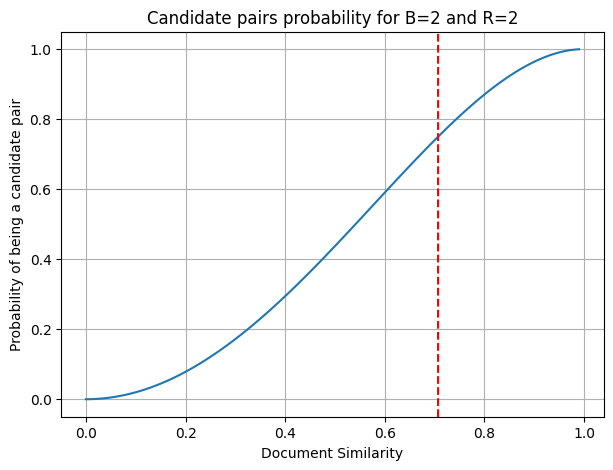

In [57]:
s=0.6
B=2
R=2
P=1-(1-s**R)**B
print("The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f" %(s, 1-(1-s**R)**B))
DrawSimPlot(B, R)

### 3.2. Hashing the band signatures

It would not be difficult then to compute the similarity of bands for every single row. If we have a match, then they will be equal and we have candidate pairs. However there is a faster approach for comparing band signatures of elements, which is **hashing**

Hashing is a procedure for transforming almost any object (provided it is unmutable) into an *unique integer value*. When two different objects share the same hashing value, we have a collision and potentially they will appear equal to each other. Even them this is a very real possibility, this is very unlikely and therefore the margin of error is very small.

There are several procedures for doing that and Python as a native method for doing it which it uses for its "hashMap" types like Dictionaries and Sets. 

Only *immutable types* can be used, like integers, floats, strings, tuples or frozensets. Not Lists, Dictionaries or Sets

Here are some example hash values from a set of types

In [58]:
print("Hash 123:                     ", hash(123))
print("Hash -123:                    ", hash(-123))
print("Hash 123.0:                   ", hash(123.0))
print("Hash '123':                   ", hash('123'))
print("Hash (1,2,3):                 ", hash((1,2,3)))
print("Hash ('1','2','3'):           ", hash(('1', '2', '3')))
print("Hash frozenset(('1','2','3')):", hash(frozenset(('1', '2', '3'))))
#print("Hash [1,2,3]:", hash([1,2,3]))



Hash 123:                      123
Hash -123:                     -123
Hash 123.0:                    123
Hash '123':                    -223852999400027361
Hash (1,2,3):                  529344067295497451
Hash ('1','2','3'):            -5066105865951749393
Hash frozenset(('1','2','3')): -5275097656522191760


[**It is expected the last (commented) line to give an error, try it!**]


We can use the hash function to hash each band signature for each document to identify which are elements that have similar values and as such create "Buckets" were potentially similar documents will appear. Each document will have as many signatures as bands, and the pair (band, hasvalue) is a "bucket". Documents that that share a bucket are probably candidate pairs

The below procedure will go for all documents, and process for each band all the buckets, grouping together all documents that share a bucket 

In [59]:
def MakeBuckets(Docs, perms, B, R, NB=9082652431):
    Buckets={}
    for d, doc in enumerate(Docs):
        for b in range(B):
            ROW=[0]*R
            for r in range(R):
                #this is the min hashing procedure
                for i,e in enumerate(perms[b*R+r]):
                    if Docs[d,e]==1:
                        ROW[r] = i
                        break
            #this is where we define the bucket for each document
            bucket = hash(tuple(ROW)) % NB
            Buckets.setdefault((b, bucket),set()).add(d)
            #print("Doc:" , d, " - Band", b, "-->", ROW, " bucket: ", bucket)
    return Buckets

bucks=MakeBuckets(Docs, perms, B, R)
bucks

{(0, 7999045404): {0},
 (1, 7022663108): {0},
 (0, 5091378548): {1, 3},
 (1, 748983391): {1, 3},
 (0, 5399261512): {2, 5},
 (1, 3592222459): {2},
 (0, 6658421542): {4},
 (1, 5163241709): {4},
 (1, 3750754686): {5}}

In [60]:

for b, buck in bucks:
    if len(bucks[(b,buck)])>1:
        print("Band", b, "suggests these similar docs:", bucks[(b,buck)])



Band 0 suggests these similar docs: {1, 3}
Band 1 suggests these similar docs: {1, 3}
Band 0 suggests these similar docs: {2, 5}


### 3.3. Implementing LSH

With the minhashing procedure it is trivial to find the similar elements. We just need to
1. Generate the $B \times R$ permutations
2. With the permutations do the minhashing for all the documents
3. Hash each band and return the buckets

A simple examination of the buckets will show the similar items

In [61]:
def LSH(Data, B, R, NB=28934501):
    P=B*R
    N,M=Data.shape
    #print("Generating %d permutations for %6.3f similarity" %(P, (1/B)**(1/R)))
    np.random.seed(3)
    perms=[np.random.permutation(M) for i in range(P)]
    buckets=MakeBuckets(Data, perms, B,R, NB)
    return buckets


bucks = LSH(Docs,B, R)
for b, buck in bucks:
    if len(bucks[(b,buck)])>1:
        print("Band", b, "suggests these similar docs:", bucks[(b,buck)])


Band 0 suggests these similar docs: {1, 3}
Band 1 suggests these similar docs: {1, 3}


we can verify that we actually found the only *slightly similar* document, by re-running the previous code, but this time showing all similarities between all 6 documents

In [62]:
for d1 in range(N-1):
    for d2 in range(d1+1, N):
        J = JaccardSim(Docs[d1], Docs[d2])
        print(d1, d2, "Jaccard Similar: %7.4f" % J)
                             

0 1 Jaccard Similar:  0.0000
0 2 Jaccard Similar:  0.0000
0 3 Jaccard Similar:  0.0000
0 4 Jaccard Similar:  0.2000
0 5 Jaccard Similar:  0.0000
1 2 Jaccard Similar:  0.0000
1 3 Jaccard Similar:  0.6000
1 4 Jaccard Similar:  0.0000
1 5 Jaccard Similar:  0.0000
2 3 Jaccard Similar:  0.0000
2 4 Jaccard Similar:  0.0000
2 5 Jaccard Similar:  0.2500
3 4 Jaccard Similar:  0.1250
3 5 Jaccard Similar:  0.1250
4 5 Jaccard Similar:  0.1429


#### 3.3.1. A Slightly bigger example

Let's create a slightly bigger problem with 60 documents with 120 attributes, keeping the same 40% sparsity. We will use B=20 and R=10 that will shift the curve to the right, meaning that we are less stringent and may miss several similar individuals; Thus a 80% similar document will have a 90% probability of being found

The probability that documents share at least one band signature if they are 0.80 similar is:  0.8809


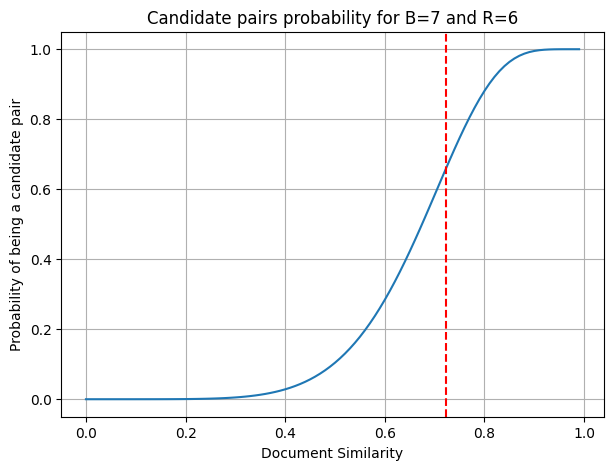

In [63]:
B=7
R=6
Docs=np.loadtxt("60docs.txt")
N,M=Docs.shape

s=.8
print("The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f" %(s, 1-(1-s**R)**B))
DrawSimPlot(B, R)


Now let's check out what we find

In [64]:
bucks = LSH(Docs, B, R)
for b, buck in bucks:
    if len(bucks[(b,buck)])>1:
        print("Band", b, "suggests these similar docs:", bucks[(b,buck)])

Band 4 suggests these similar docs: {0, 13}
Band 6 suggests these similar docs: {0, 13}
Band 4 suggests these similar docs: {41, 11}
Band 0 suggests these similar docs: {58, 19, 44}
Band 2 suggests these similar docs: {58, 19, 44}
Band 3 suggests these similar docs: {19, 44}
Band 5 suggests these similar docs: {19, 44}
Band 6 suggests these similar docs: {19, 44}
Band 4 suggests these similar docs: {32, 56}
Band 5 suggests these similar docs: {32, 56}
Band 6 suggests these similar docs: {32, 56}
Band 1 suggests these similar docs: {58, 44}


Let's confirm or disprove the results found by checking the Jaccard similarity of all pairs. [The approach below is not very efficient and we will not even remove the duplicate pairs, it is just for academic purposes to show out the results found]

In [65]:
for b, buck in bucks:
    if len(bucks[(b,buck)])>1:
        doc_ids=np.array(list(bucks[(b,buck)]))
        idx = np.stack(np.triu_indices(len(doc_ids), k=1), axis=-1)
        sim_pairs=doc_ids[idx]
        for d1, d2 in sim_pairs:
            print ("Jaccard Similarity between docs %d and %d is: %7.4f" %(d1,d2,JaccardSim(Docs[d1], Docs[d2])))



Jaccard Similarity between docs 0 and 13 is:  0.8889
Jaccard Similarity between docs 0 and 13 is:  0.8889
Jaccard Similarity between docs 41 and 11 is:  0.2368
Jaccard Similarity between docs 58 and 19 is:  0.8525
Jaccard Similarity between docs 58 and 44 is:  0.8966
Jaccard Similarity between docs 19 and 44 is:  0.9474
Jaccard Similarity between docs 58 and 19 is:  0.8525
Jaccard Similarity between docs 58 and 44 is:  0.8966
Jaccard Similarity between docs 19 and 44 is:  0.9474
Jaccard Similarity between docs 19 and 44 is:  0.9474
Jaccard Similarity between docs 19 and 44 is:  0.9474
Jaccard Similarity between docs 19 and 44 is:  0.9474
Jaccard Similarity between docs 32 and 56 is:  0.8846
Jaccard Similarity between docs 32 and 56 is:  0.8846
Jaccard Similarity between docs 32 and 56 is:  0.8846
Jaccard Similarity between docs 58 and 44 is:  0.8966


With one exception (pair 41, 11) all results show similarities above 80%. Let's check if this covers all cases by verifying ALL possible distances and displaying all cases with scores above 70%

In [66]:
for d1 in range(N-1):
    for d2 in range(d1+1, N):
        J = JaccardSim(Docs[d1], Docs[d2])
        if J>0.7:
            print(d1, d2, "Jaccard Similar: %7.4f" % J)


0 13 Jaccard Similar:  0.8889
19 44 Jaccard Similar:  0.9474
19 58 Jaccard Similar:  0.8525
32 56 Jaccard Similar:  0.8846
44 58 Jaccard Similar:  0.8966


All the above verifiable similar docuemnts were discovered the algorithm!

### 3.4. Optimizing LSH


The MinHash algorithm, although sound and working, is not very fast, especially if the matrix is very sparse (which is very often the case). This is because the verification of the first bit that is set can take a long time forcing to many iterations until a 1 is actually found.

There are several optimizations to the MinHash procedure. One of very simple implementation in Python is to take advantage of Set Operations, like Set Intersection and Set Subtraction

The devised procedure works as follows:

1. First transpose the Document matrix, reorganizing it in a list of sets. So instead of having N rows, we will have M rows, one for each possible column. In each row, we will store it as as Set of all the documents that have that bit set to one
2. Going through the each permutation, initialize a Set `L` with all the document Ids, set a `SIG` array filled with Zeros, set counter `C` to Zero
    1. Select bit (`B`) of the current permutation
    2. Elliminate from `L` all documents that have bit `B` set
    3. Set the corresponding documents of the `SIG` array equal to `C`
    4. increment `C`
    5. repeat steps above going through the next permutation bits and Stop when Set `L` is zero


This is a very crude implementation of the above procedure, called `LSHT` , for `LSH Transpose`

**NOTE** The Set logical operations in Python sets can be VERY Slow, especially if the data is not very sparse. Simple optimizations could be easily made, but would obfuscate the simplicity of the whole procedure


In [67]:
def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets={}
    all_docs=set(range(N))
    for b in range(B):
        SIGS=np.zeros((N, R), dtype="int32")           # initializes line sig
        for r in range(R):
            perm=perms[b*R+r]
            L=all_docs.copy()                         # gets all docs as a set
            i=0 
            while len(L)>0:
                elem=perm[i]                          # get new element  from permutation
                docs_found=TDocs[elem] & L            # get all the docs with a set bit on that elem that are still on the list
                if len(docs_found)>0:                 # if anything was found
                    SIGS[list(docs_found), r]=i       #   set the line sig to the current position from the perm
                    L=L-docs_found                    #   update the current list removing the found docs
                i+=1                                  # update the current position
                if i==M:                              #this is the case that the document is empty 
                    SIGS[list(L), r]=i                # Highly unlikely in a real data set  
                    L={}
                                                      # we have completed the signature for a given band, 
                                                      # now make the hashes for each document
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket),set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N,M=Data.shape
    #transpose the data set
    DT=Data.T
    DataT=[set(np.where(DT[i]==1)[0]) for i in range(M)]
    P=B*R
    np.random.seed(3)
    #print("Generating %d permutations for %6.3f similarity" %(P, (1/B)**(1/R)))
    perms=[np.random.permutation(M) for i in range(P)]
    buckets=MakeBucketsT(DataT, perms, N, B,R, NB)
    return buckets


Let's check to see if the results are actually the same as `LSH`

In [68]:
bucks = LSHT(Docs, B, R)
for b, buck in bucks:
    if len(bucks[(b,buck)])>1:
        print("Band", b, "suggests these similar docs:", bucks[(b,buck)])


Band 0 suggests these similar docs: {58, 19, 44}
Band 1 suggests these similar docs: {58, 44}
Band 2 suggests these similar docs: {58, 19, 44}
Band 3 suggests these similar docs: {19, 44}
Band 4 suggests these similar docs: {0, 13}
Band 4 suggests these similar docs: {41, 11}
Band 4 suggests these similar docs: {32, 56}
Band 5 suggests these similar docs: {19, 44}
Band 5 suggests these similar docs: {32, 56}
Band 6 suggests these similar docs: {0, 13}
Band 6 suggests these similar docs: {19, 44}
Band 6 suggests these similar docs: {32, 56}


Even though the presentation order is different the results are EXACTLY the same

### 3.5 Performance comparison

Let's compare implementations for an even larger dataset of "documents" randomly generated with 99% sparsity

In [69]:
N=600
M=12000
B=20
R=5
np.random.seed(20)
Docs=(np.random.random((N,M))>0.99)*1
%timeit bucks = LSH(Docs, B, R)
%timeit bucks = LSHT(Docs, B, R)


1.54 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
365 ms ± 7.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 3.5.1 importance of the database size (Rows and Columns)

For the above data, the optimized code seems about 5.5 times faster!

Let's do a series of tests seeing what happens when N, M or the sparsity changes. First let's experiment with a fixed 99% sparsity, and change N and M

**WARNING** The Procedure below will stress your computer a bit, because it is testing larger and larger matrices and evaluating the performance of both algorithms

In [70]:
from time import time
DM_LSH={}
DM_LSHT={}
DN_LSH={}
DN_LSHT={}

for N in [1000, 2000, 4000, 8000]:
    for M in [2000, 4000, 8000, 16000]:
        np.random.seed(123)
        Docs=(np.random.random((N,M))>0.99)*1                  ## <- here is the sparsity!
        t1=time()
        bucks = LSH(Docs, B, R)                                 
        t2=time()
        bucks = LSHT(Docs, B, R) 
        t3=time()
        print("%d\t%d\t%7.2f\t%7.2f" %(N,M,t2-t1, t3-t2))
        DN_LSH.setdefault(N,[] ).append(t2-t1)
        DN_LSHT.setdefault(N,[]).append(t3-t2)
        DM_LSH.setdefault(M,[] ).append(t2-t1)
        DM_LSHT.setdefault(M,[]).append(t3-t2)


1000	2000	   2.47	   0.42
1000	4000	   2.54	   0.45
1000	8000	   2.48	   0.53
1000	16000	   2.63	   0.66
2000	2000	   4.86	   0.87
2000	4000	   4.88	   0.97
2000	8000	   4.87	   1.11
2000	16000	   5.03	   1.56
4000	2000	   9.83	   1.66
4000	4000	   9.89	   1.68
4000	8000	   9.83	   2.17
4000	16000	   9.80	   3.09
8000	2000	  19.66	   3.03
8000	4000	  19.71	   3.34
8000	8000	  19.67	   4.08
8000	16000	  19.68	   5.73


Let's have a better appreciation by looking at the results graphically

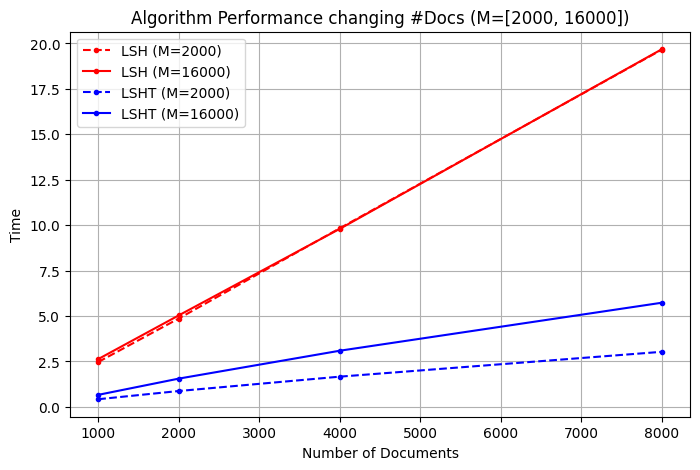

In [71]:
x = [1000, 2000, 4000, 8000]
plt.figure(figsize=(8,5))
plt.plot(x, DM_LSH[2000],   "--r.", label="LSH (M=2000)")
plt.plot(x, DM_LSH[16000],  "-r.",  label="LSH (M=16000)")
plt.plot(x, DM_LSHT[2000],  "--b.", label="LSHT (M=2000)")
plt.plot(x, DM_LSHT[16000], "-b.",  label="LSHT (M=16000)")
plt.title("Algorithm Performance changing #Docs (M=[2000, 16000])")
plt.ylabel("Time")
plt.xlabel("Number of Documents")
plt.grid()
plt.legend()
plt.show()

**Exercise**

* Comment these results
* Compare both approaches
* What if you had 1 million documents with 16000 columns, and similar sparsity, how much would it take to identify all candidate pairs using both approaches


Now let's check the importance of the number of columns for 2 different database sizes

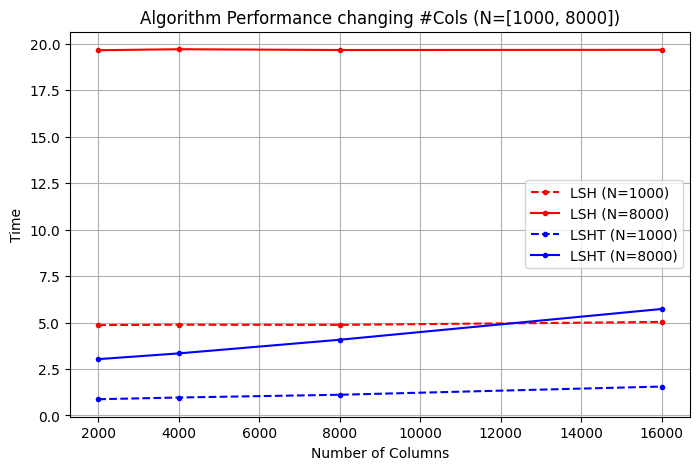

In [72]:
x=np.array([2000, 4000, 8000, 16000])

plt.figure(figsize=(8,5))
plt.plot(x, DN_LSH[2000], "--r.",  label="LSH (N=1000)")
plt.plot(x, DN_LSH[8000], "-r.",  label="LSH (N=8000)")
plt.plot(x, DN_LSHT[2000], "--b.", label="LSHT (N=1000)")
plt.plot(x, DN_LSHT[8000], "-b.", label="LSHT (N=8000)")
plt.title("Algorithm Performance changing #Cols (N=[1000, 8000])")
plt.ylabel("Time")
plt.xlabel("Number of Columns")
plt.grid()
plt.legend()
plt.show()

Here we can see that the number of columns is not a factor in defining performance, although the optimized approach appears slightly more susceptible to the increase in the number of dimensions

#### 3.5.2. The influence of Sparsity on Performance

One of the critical data characteristics is the level of sparsity. The more sparse the data matrix is the more difficult it is to find items and the slowest it is to process the signatures, even though the number of documents and columns is the same. We will set the number of documents at 2000 and change the sparcity level


In [73]:
from time import time
DM_LSH={}
DM_LSHT={}
Ds_LSH={}
Ds_LSHT={}

N= 2000
for M in [2000, 4000, 8000, 16000]:
    for s in [0.7, 0.9, 0.95, 0.98, 0.99, 0.995, 0.9975]:
        np.random.seed(123)
        Docs=(np.random.random((N,M))>s)*1
        t1=time()
        bucks = LSH(Docs, B, R)
        t2=time()
        bucks = LSHT(Docs, B, R)
        t3=time()
        print("%6.3f\t%d\t%7.2f\t%7.2f" %(s,M,t2-t1, t3-t2))
        DM_LSH.setdefault(M,[] ).append(t2-t1)
        DM_LSHT.setdefault(M,[]).append(t3-t2)
        Ds_LSH.setdefault(s,[] ).append(t2-t1)
        Ds_LSHT.setdefault(s,[]).append(t3-t2)


 0.700	2000	   0.41	   0.49
 0.900	2000	   0.58	   0.50
 0.950	2000	   1.06	   0.41
 0.980	2000	   2.57	   0.55
 0.990	2000	   4.96	   0.77
 0.995	2000	   9.84	   1.33
 0.998	2000	  19.54	   1.80
 0.700	4000	   0.28	   0.83
 0.900	4000	   0.69	   0.54
 0.950	4000	   1.16	   0.55
 0.980	4000	   2.52	   0.76
 0.990	4000	   4.93	   0.99
 0.995	4000	   9.99	   1.36
 0.998	4000	  19.53	   1.95
 0.700	8000	   0.39	   1.50
 0.900	8000	   0.71	   0.91
 0.950	8000	   1.12	   1.04
 0.980	8000	   2.64	   0.98
 0.990	8000	   5.00	   1.19
 0.995	8000	  10.14	   1.54
 0.998	8000	  19.95	   2.13
 0.700	16000	   0.42	   3.09
 0.900	16000	   0.75	   1.74
 0.950	16000	   1.23	   1.50
 0.980	16000	   2.55	   1.47
 0.990	16000	   4.99	   1.65
 0.995	16000	   9.98	   2.28
 0.998	16000	  20.07	   2.80


This will need to be plotted out with some care and a log-log plot will be more informative. Also we will use `1-sparsity` as it is more capable of identifying the the important performance differences

In the first place it is possible to verify that for sparsity < 0.9 (the right most points of the graph), the bare bones implementation LSH is actually faster, but also that its performance degrades very fast as the sparsity increases, the graph suggesting a power law. Also, there appears to be no significant difference by changing the number of columns in the data set



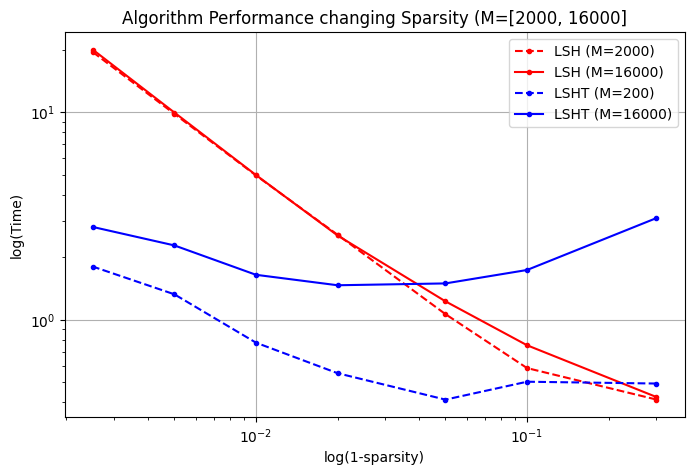

In [90]:
import matplotlib.pyplot as plt
x=np.array( [0.7, 0.9, 0.95, 0.98, 0.99, 0.995, 0.9975])
x=1-x
plt.figure(figsize=(8,5))
plt.plot(x, DM_LSH[2000],  "--r.", label="LSH (M=2000)")
plt.plot(x, DM_LSH[16000], "-r.",  label="LSH (M=16000)")
plt.plot(x, DM_LSHT[2000], "--b.", label="LSHT (M=200)")
plt.plot(x, DM_LSHT[16000],"-b.",  label="LSHT (M=16000)")
plt.title("Algorithm Performance changing Sparsity (M=[2000, 16000]")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("log(Time)")
plt.xlabel("log(1-sparsity)")
plt.grid()
plt.legend()

plt.show()

Finally let's just examine the rather unintersting graph of the performance as related to the  number of columns

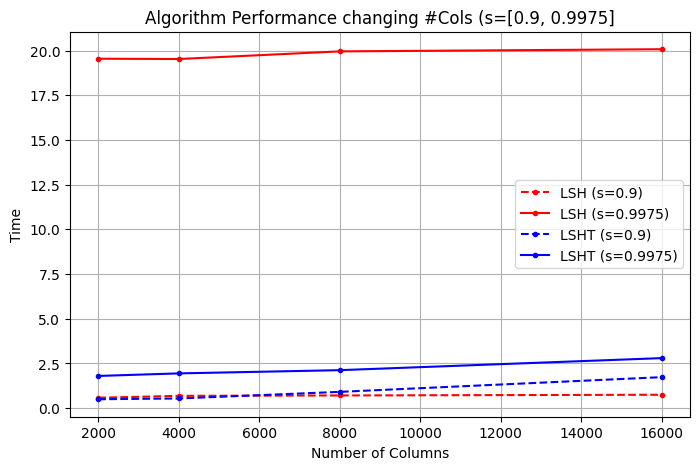

In [75]:
import matplotlib.pyplot as plt
x=np.array( [2000, 4000, 8000, 16000])
plt.figure(figsize=(8,5))
plt.plot(x, Ds_LSH[0.9],  "--r.", label="LSH (s=0.9)")
plt.plot(x, Ds_LSH[0.9975], "-r.",label="LSH (s=0.9975)")
plt.plot(x, Ds_LSHT[0.9], "--b.", label="LSHT (s=0.9)")
plt.plot(x, Ds_LSHT[0.9975],"-b.",label="LSHT (s=0.9975)")
plt.title("Algorithm Performance changing #Cols (s=[0.9, 0.9975]")
plt.ylabel("Time")
plt.xlabel("Number of Columns")
plt.grid()
plt.legend()

plt.show()

Again the number of columns does not seam to be very relevant, but two extreme values in sparsity have an enormous impact, especially in the original implementation


**Exercises:**

* if you knew the sparsity of the set of 1 million documents of the previous exercise  was 0.8 what impact if would have on your choice of algorithms
* [to do at home] Make a LSH class that is able to create the document buckets and then is capable of identifying all the existing candidate pair documents for any set of documents submitted


## 4. A Real World Example - The Wikipedia Dataset

Here we will put all these principles into practice by using the Wikipedia set of >14,500 documents from lab class 1. We will use the documents preprocessed and tokenized and stored in a Python Pickle


In [76]:
import pickle
words_text_sets, all_words=pickle.load(open("wikipedia1.pickle", "rb"))


### 4.1 Data preprocessing

The functions below produce indexing of all words and the document sparse-like matrix with all the word indexes

In [77]:
def make_word_indexes(words): 
     return dict(zip(words, range(len(words))))

def make_indexed_docs(docs, words):
    N = len(docs)
    M = len(words)
    #S_mat = dok_array((N, M), dtype=np.int8)
    S_mat=[]
    for i in range(N):
        word_idxs=set([words[w] for w in docs[i]])
        #S_mat[i,word_idxs]=1
        S_mat.append(word_idxs)
    return S_mat

def remove_empty_docs(words_text_sets):
    return [doc for doc in words_text_sets if len(doc)>0]

word_idxs       = make_word_indexes(all_words) 
words_text_sets = remove_empty_docs(words_text_sets)
idx_docs        = make_indexed_docs(words_text_sets, word_idxs)

print("N. of documents:", len(idx_docs))
print("N. of unique words:", len(word_idxs))

N. of documents: 14676
N. of unique words: 243490


### 4.2. The problem of computing all distances

To take a look at the anticipated problem of searching similar documents, let's evaluate how much does it cost computationally to search for similarities between subsets of this data set

In [78]:
import time
#check the similarities between the first N documents
N = 200
ndocs = 10*2**np.arange(1, 9)
times=[]
for N in ndocs:
    t1=time.time()
    for i in range(N-1):
        d1=idx_docs[i]
        for j in range(i+1, N):
            d2=idx_docs[j]
            s=JaccardSimS(d1, d2)  #compute similarity
    t2=time.time()
    print("To search for similarities between the first %d docs it took %7.4f secs" % (N, t2-t1))
    times.append(t2-t1)


To search for similarities between the first 20 docs it took  0.0101 secs
To search for similarities between the first 40 docs it took  0.0181 secs
To search for similarities between the first 80 docs it took  0.0622 secs
To search for similarities between the first 160 docs it took  0.2309 secs
To search for similarities between the first 320 docs it took  0.9034 secs
To search for similarities between the first 640 docs it took  3.2916 secs
To search for similarities between the first 1280 docs it took 13.2833 secs
To search for similarities between the first 2560 docs it took 51.1149 secs


Let's plot the curve and verify it's parabollic shape


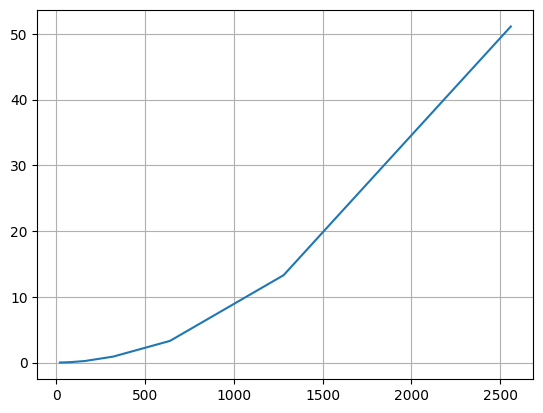

In [79]:
import matplotlib.pyplot as plt
plt.plot(ndocs, times)
plt.grid()
plt.show()

We can see that we can fit a almost perfect straight line if we use the squere root of the time and compute its slope

slope: 0.002775279298246215


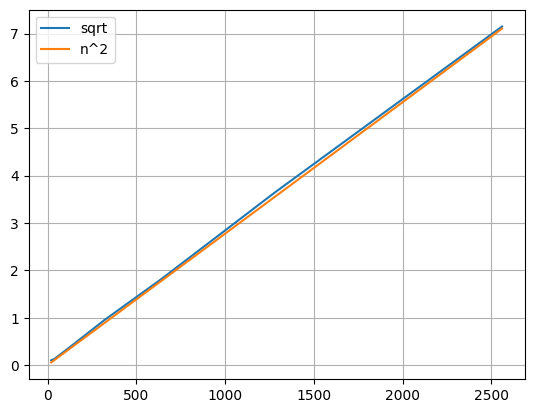

In [91]:
sqrt_times=np.sqrt(times)
slope=(sqrt_times[-1]- sqrt_times[0])/(ndocs[-1]- ndocs[0])
print("slope:", slope)
plt.plot(ndocs, sqrt_times, label="sqrt")
plt.plot(ndocs, ndocs*slope, label="n^2")
plt.legend()
plt.grid()
plt.show()

With this slope we can now compute how much time would it take to compute the full dataset:

In [92]:
N = len(idx_docs)
print("The time required to compute all similarities is %7.4f seconds" % (slope*N)**2) 


The time required to compute all similarities is 1658.9328 seconds


### 4.3. Computing Potential similarities for the documents with LSHT

We will need to slightly tweak the LSHT so that it can encompass our data in its original format

In [93]:
def LSHTs(docs, words, B, R, NB=28934501, verbose=True):
    N,M = len(docs), len(words)
    if verbose: print("transpose the data set")
    data=[[] for i in range(M)]
    for i, doc in enumerate(docs):
        for word in doc: data[word].append(i)
    dataT=[set(L) for L in data]
    P=B*R
    np.random.seed(3)
    if verbose: print("Generating %d permutations for %6.3f similarity" %(P, (1/B)**(1/R)))
    perms=[np.random.permutation(M) for i in range(P)]
    if verbose: print("Computing buckets...")
    t1=time.time()
    buckets=MakeBucketsT(dataT,perms, N, B, R, NB)
    t2=time.time()
    if verbose: print("Finished bucket generation in %7.4f seconds"% (t2-t1))
    return buckets


What is the level of similarity we are looking for? Let's look for 60% similarity documents with `B=30` and `R=5`


In [94]:
B = 80
R = 8
s = 0.60
P = 1-(1-s**R)**B
print("The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f" %(s, P))
s = 0.70
P = 1-(1-s**R)**B
print("The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f" %(s, P))

The probability that documents share at least one band signature if they are 0.60 similar is:  0.7421
The probability that documents share at least one band signature if they are 0.70 similar is:  0.9913


So we will probably get most documents with 70% similarity (and above) and will loose about 26% of documents that have 60% similarity

If `B = 80` and `R = 8`

In [84]:

B, R = 80, 8
bucks = LSHTs(idx_docs, word_idxs, B, R)

transpose the data set
Generating 640 permutations for  0.578 similarity
Computing buckets...
Finished bucket generation in 191.1947 seconds


### 4.4. Analizing the results

In the generated buckets we should have all candidate similar documents with about 70% similarity
Let's check one non-singular bucket and print out their similarities:

In [95]:
for b, buck in bucks:
    if len(bucks[(b,buck)])>1:
        print("Band", b, "suggests these similar docs:", bucks[(b,buck)])
        break

from itertools import combinations
combs = combinations(bucks[(b,buck)], 2)
for i, j in combs:
    print("Documents %6d and %6d are in truth %7.4f similar"  % (i , j, JaccardSimS(idx_docs[i], idx_docs[j])))

Band 0 suggests these similar docs: {8, 512, 536}
Documents      8 and    512 are in truth  0.7397 similar
Documents      8 and    536 are in truth  0.7436 similar
Documents    512 and    536 are in truth  0.8030 similar


In [96]:
print("WORDS from Doc25):\n", " ".join(words_text_sets[25]))
print("\nWORDS from Doc4957):\n", " ".join(words_text_sets[4957]))

print("\nCommon Words:\n", " ".join(words_text_sets[25]  & words_text_sets[4957]))

WORDS from Doc25):
 germany category:living at category:german summer united german born alfred category:wrestlers people in olympics references wrestlers category:sportspeople the thuringia men's category: from welterweight male competed team he freestyle wrestler of november sport births category:olympic is tischendorf a

WORDS from Doc4957):
 germany category:living at jena category:german summer united german born category:wrestlers people category:people in luschnig olympics references wrestlers the men's category: from male competed team featherweight he freestyle wrestler of sport births christian category:olympic is a december

Common Words:
 germany category:living at category:german summer united german born category:wrestlers people in olympics references wrestlers the category: men's from male competed team he freestyle wrestler of sport births category:olympic is a


Getting all pairs of similar documents could be easily accomplished like this

In [87]:
def get_all_similar_docs(buckets):
    sim_docs=[]
    for b, buck in buckets:
        if len(buckets[(b,buck)])>1:
            sim_docs+=combinations(buckets[(b,buck)], 2)
    sim_docs=set(sim_docs)
    D={}
    for i,j in sim_docs:
        D.setdefault(i, set()).add(j)
        D.setdefault(j, set()).add(i)
    return D 

sim_docs = get_all_similar_docs(bucks)


Verify the similar documents for document #21

In [88]:

i=21
for j in sim_docs[i]:
    print("Documents %6d, and %6d, are %7.4f similar"  % (i , j, JaccardSimS(idx_docs[i], idx_docs[j])))

Documents     21, and   9830, are  0.3571 similar
Documents     21, and   3722, are  0.4545 similar
Documents     21, and   5290, are  0.5111 similar
Documents     21, and   9994, are  0.7250 similar
Documents     21, and   1996, are  0.4783 similar
Documents     21, and  10574, are  0.5333 similar
Documents     21, and  10575, are  0.5778 similar
Documents     21, and   3984, are  0.4894 similar
Documents     21, and   1423, are  0.5111 similar
Documents     21, and   1970, are  0.5238 similar
Documents     21, and  11986, are  0.6429 similar
Documents     21, and  11156, are  0.5778 similar
Documents     21, and  13235, are  0.5111 similar
Documents     21, and   5266, are  0.4894 similar
Documents     21, and   1271, are  0.4583 similar
Documents     21, and  14521, are  0.5778 similar
Documents     21, and  11132, are  0.5116 similar
Documents     21, and   2783, are  0.6829 similar


#### Exercises

1. Comment the above results in performance and quality
2. There are no similar documents found to document 3
    1. Check out that is the case
    2. What is the closest document to Document 3
    3. Compare the actual common words to both documents
    4. Is that level of similarity to be expected?
3. Check the actual similarities for document 14
    1. Compare the results to the previous exercise
    2. Comment the results found


In [101]:
### Exercise 2.A solution
3 in sim_docs

False

In [115]:
#exercise 2.C solution

i=3
dist = []
for k, docs in enumerate(words_text_sets):
    if k!=i:
        dist.append(JaccardSimS( words_text_sets[i], words_text_sets[k] ) )
    else: dist.append(-1)
np.argmax(dist)

28

In [116]:
dist[28]

0.1577574967405476

In [112]:
#Exercise 3.A solution

i=14
dist = []
for k, docs in enumerate(words_text_sets):
    if k!=i:
        dist.append(JaccardSimS( words_text_sets[i], words_text_sets[k] ) )
    else: dist.append(-1)
np.argmax(dist)

36

In [113]:
dist[36]

0.5813953488372093

In [114]:
dist[23]

0.5476190476190477

In [111]:
sim_docs[14]

{23, 315}